# A Farm Planning Problem
This notebook is based on a problem posed in Chapter 11 of the AIMMS documentation:<br>
https://documentation.aimms.com/_downloads/AIMMS_modeling.pdf

In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**Problem Description:**<br>
Imagine a family farm, where different types of crops are grown at different times throughout the year. The limiting factors in producing crops on the farm include land, labor, and water. The farm needs to figure out how much of different crops they need to grow with the goal of maximizing revenue while optimizing the use of limited resources at their disposal.<br> 
Different crops can be grown at different times of the year, and the farm follows an annual schedule. The following table shows what fraction of the month, each crop can be grown on the farm:

In [2]:
land_df = pd.DataFrame()
land_df["month"] = ["January", "February", "March", "April", "May", "June", "July", "August", "September", \
                     "October", "November", "December"]
land_df["Wheat"] = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0.5, 1]
land_df["Beans"] = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0.25, 1]
land_df["Onions"] = [1, 1, 1, 1, 0.25, 0, 0, 0, 0, 0, 0.5, 1]
land_df["Cotton"] = [0, 0, 0.5, 1, 1, 1, 1, 1, 1, 1, 0.75, 0]
land_df["Maize"] = [0, 0, 0, 0, 0.25, 1, 1, 1, 1, 0.5, 0, 0]
land_df["Tomatoes"] = [0, 0, 0, 0, 0, 0, 0.75, 1, 1, 1, 0.75, 0]

land_df.head()

,month,Wheat,Beans,Onions,Cotton,Maize,Tomatoes
0,January,1.0,1.0,1.00,0.0,0.00,0.0
1,February,1.0,1.0,1.00,0.0,0.00,0.0
2,March,1.0,1.0,1.00,0.5,0.00,0.0
3,April,1.0,1.0,1.00,1.0,0.00,0.0
4,May,1.0,0.0,0.25,1.0,0.25,0.0


The labor available at the farm includes the farmer's family and part-time or full-time external labor. There are 1.5 members of the family available to work on the farm. The cost for a family member is \\$4,144 for a year, while the cost of a permanent external labor is \\$5,180 per year, and the cost of temporary external labor is \\$4 per hour. The following table shows the number of man-hours needed in each month to grow the crops.

In [3]:
labor_df = pd.DataFrame()
labor_df["month"] = ["January", "February", "March", "April", "May", "June", "July", "August", "September", \
                     "October", "November", "December"]
labor_df["Wheat"] = [14, 4, 8, 8, 137, 0, 0, 0, 0, 0, 19, 11]
labor_df["Beans"] = [6, 6, 6, 128, 0, 0, 0, 0, 0, 0, 60, 6]
labor_df["Onions"] = [41, 40, 40, 155, 19, 0, 0, 0, 0, 0, 89, 37]
labor_df["Cotton"] = [0, 0, 40, 40, 72, 16, 12, 16, 8, 46, 34, 0]
labor_df["Maize"] = [0, 0, 0, 0, 34, 40, 57, 64, 35, 9, 0, 0]
labor_df["Tomatoes"] = [0, 0, 0, 0, 0, 0, 136, 120, 96, 56, 48, 0]
labor_df["hours"] = [160, 160, 184, 176, 168, 176, 176, 176, 176, 168, 176, 176]

labor_df.head()

,month,Wheat,Beans,Onions,Cotton,Maize,Tomatoes,hours
0,January,14,6,41,0,0,0,160
1,February,4,6,40,0,0,0,160
2,March,8,6,40,40,0,0,184
3,April,8,128,155,40,0,0,176
4,May,137,0,19,72,34,0,168


The following table shows water requirements for growing the crops at each month. The total amount of water available for farming at each month is 5 kcub. Furthermore, the total amount of water available to the farm for the year is 50 kcub.And the price of water is \\$10 per kcub.

In [4]:
water_df = pd.DataFrame()
water_df["month"] = ["January", "February", "March", "April", "May", "June", "July", "August", "September", \
                     "October", "November", "December"]
water_df["Wheat"] = [0.535, 0.802, 0.556, 0.059, 0, 0, 0, 0, 0, 0, 0.373, 0.456]
water_df["Beans"] = [0.438, 0.479, 0.505, 0.142, 0, 0, 0, 0, 0, 0, 0.272, 0.335]
water_df["Onions"] = [0.452, 0.507, 0.640, 0.453, 0, 0, 0, 0, 0, 0, 0, 0.305]
water_df["Cotton"] = [0, 0, 0.197, 0.494, 1.047, 1.064, 1.236, 0.722, 0.089, 0, 0, 0]
water_df["Maize"] = [0, 0, 0, 0, 0.308, 0.896, 1.318, 0.953, 0.205, 0, 0, 0]
water_df["Tomatoes"] = [0, 0, 0, 0, 0, 0, 0.120, 0.241, 0.525, 0.881, 0.865, 0]

water_df.head()

,month,Wheat,Beans,Onions,Cotton,Maize,Tomatoes
0,January,0.535,0.438,0.452,0.000,0.000,0.0
1,February,0.802,0.479,0.507,0.000,0.000,0.0
2,March,0.556,0.505,0.640,0.197,0.000,0.0
3,April,0.059,0.142,0.453,0.494,0.000,0.0
4,May,0.000,0.000,0.000,1.047,0.308,0.0


 Based on historical data, we can estimate the amount of yield for each crop as well as the expected price. The following table shows the expected yields and prices:

In [5]:
crop_df = pd.DataFrame()
crop_df["crop"] = ["Wheat", "Beans", "Onions", "Cotton", "Maize", "Tomatoes"]
crop_df["yield (ton/ha)"] = [1.50, 1.00, 6.00, 1.50, 1.75, 6.00]
crop_df["price ($/ton)"] = [1000, 2000, 750, 3500, 700, 800]

crop_df

,crop,yield (ton/ha),price ($/ton)
0,Wheat,1.50,1000
1,Beans,1.00,2000
2,Onions,6.00,750
3,Cotton,1.50,3500
4,Maize,1.75,700
5,Tomatoes,6.00,800


The family also consumes a portion of the yield for their own purposes. in order to have a balanced diet, the family can choose from 3 different options for their own consumption. The following table shows these 3 bundles:

In [6]:
bundle_df = pd.DataFrame()
bundle_df["crop"] = ["Wheat", "Beans", "Onions", "Cotton", "Maize", "Tomatoes"]
bundle_df["option 1 (tons)"] = [0, 1.20, 0, 0, 0.15, 0.25]
bundle_df["option 2 (tons)"] = [0, 0.73, 0, 0, 1.5, 0.25]
bundle_df["option 3 (tons)"] = [0, 0.70, 0, 0, 1.00, 0.75]

bundle_df

,crop,option 1 (tons),option 2 (tons),option 3 (tons)
0,Wheat,0.00,0.00,0.00
1,Beans,1.20,0.73,0.70
2,Onions,0.00,0.00,0.00
3,Cotton,0.00,0.00,0.00
4,Maize,0.15,1.50,1.00
5,Tomatoes,0.25,0.25,0.75


We can use the following notation for the mathematical representation of the problem:<br>
**Indices:**<br> 
c$\;\;\;\;\;\;\;\;\;\;$crops<br>
t$\;\;\;\;\;\;\;\;\;$months<br>
b$\;\;\;\;\;\;$consumption bundles<br>
**Parameters (crop):**<br>
$y_{c}$$\;\;\;\;\;\;\;\;$yield of crop c<br>
$p_{c}$$\;\;\;\;\;\;\;\;$price of crop c<br>
$d_{cb}$$\;\;\;\;\;\;\;\;$amount of crop c in bundle b<br>
**Parameters (land):**<br>
L$\;\;\;\;\;\;\;\;\;\;$land available<br>
$l_{tc}$$\;\;\;\;\;\;\;\;$fraction of month t that crop c occupies land<br>
**Parameters (labor):**<br>
$v_{tc}$$\;\;\;\;\;\;\;\;$labor required of crop c during month t<br>
$r^{F}$$\;\;\;\;\;\;\;\;$annual wage rate family labor>br>
$r^{P}$$\;\;\;\;\;\;\;\;$annual wage rate permanent labor<br>
$r^{T}$$\;\;\;\;\;\;\;\;$hourly wage rate temporary labor<br>
$h_{t}$$\;\;\;\;\;\;\;\;$working hours in month t<br>
$V^{F}$$\;\;\;\;\;\;\;\;$family labor available<br>
**Parameters (water):**<br>
$W$$\;\;\;\;\;\;\;\;$annual amount of water available<br>
$w_{t}$$\;\;\;\;\;\;\;\;$limit on use of water in month t<br>
$R_{tc}$$\;\;\;\;\;\;\;\;$water requirement for crop c in month t<br>
$p^{W}$$\;\;\;\;\;\;\;\;$price of water<br>
**Variables:**<br>
$x_{c}$$\;\;\;\;\;\;\;\;$amount of crop c planted<br>
$V^{P}$$\;\;\;\;\;\;\;\;$permanent labor hired<br>
$V_{t}^{T}$$\;\;\;\;\;\;\;\;$temporary labor hired in t<br>
$s_{c}$$\;\;\;\;\;\;\;\;$sales of crop c<br>
$z_{b}$$\;\;\;\;\;\;\;\;$fraction of bundle b consumed<br>
So the formulation will look as follows:<br>
**Maximize:**
$$
\underset{}{max} \sum_{c}^{} p_{c}s_{c} - r^{F}V^{F} - r^{P}V^{P} - r^{T}\sum_{t}^{}V_{t}^{T} - p^{W}\sum_{tc}^{}R_{tc}x_{c}
$$
**Subject to:**
$$
\sum_{c}^{}l_{tc}x_{c} \le L \;\;\;\;\;\;\;\; \forall t
$$
$$
\sum_{c}^{}v_{tc}x_{c} \le h_{t}(V^{F}+V^{P})+V_{t}^{T} \;\;\;\;\;\;\;\; \forall t
$$
$$
\sum_{c}^{}R_{tc}x_{c} \le w_{t} \;\;\;\;\;\;\;\; \forall t
$$
$$
\sum_{tc}^{}R_{tc}x_{c} \le W \;\;\;\;\;\;\;\; \forall t
$$
$$
y_{c}x_{c} = \sum_{b}^{} d_{cb}z_{b} + s_{c} \;\;\;\;\;\;\;\; \forall c
$$
$$
\sum_{b}^{} z_{b}=1
$$
$$
x_{c},s_{c} \ge 0 \;\;\;\;\;\;\;\; \forall c,\;\;\;\ V_{t}^{T} \ge 0 \;\;\;\;\;\;\;\; \forall t,\;\;\;\ z_{b} \ge 0 \;\;\;\;\;\;\;\; \forall b,\;\;\;\ V^{P} \ge 0
$$

In [7]:
model = ConcreteModel()

#Indices
model.c = RangeSet(6)
model.t = RangeSet(len(land_df))
model.b = RangeSet(3)

#Parameters
model.L = Param(initialize=10, within=Reals)
model.rF = Param(initialize=4144, within=Reals)
model.rP = Param(initialize=5180, within=Reals)
model.rT = Param(initialize=4, within=Reals)
model.VF = Param(initialize=1.5, within=Reals)
model.W = Param(initialize=50, within=Reals, mutable=True)
model.w = Param(model.t, initialize=5, within=Reals)
model.pW = Param(initialize=4, within=Reals)

#Parameters (crop)
def yield_c(model, c):
    return crop_df.loc[c-1,"yield (ton/ha)"]
model.y = Param(model.c, initialize=yield_c, within=Reals)

def price_c(model, c):
    return crop_df.loc[c-1,"price ($/ton)"]
model.p = Param(model.c, initialize=price_c, within=Reals)

def crop_bundle(model, c, b):
    column = "option " + str(b) + " (tons)"
    return bundle_df.loc[c-1,column]
model.d = Param(model.c, model.b, initialize=crop_bundle, within=Reals)

#Parameters (land)
def month_crop(model, t, c):
    return land_df.iloc[t-1,c]
model.l = Param(model.t, model.c, initialize=month_crop, within=Reals)

#Parameters (labor)
def labor_crop(model, t, c):
    return labor_df.iloc[t-1,c]
model.v = Param(model.t, model.c, initialize=labor_crop, within=Reals)

def labor_total(model, t):
    return labor_df.loc[t-1,"hours"]
model.h = Param(model.t, initialize=labor_total, within=Reals)

#Parameters (water)
def water_crop(model, t, c):
    return water_df.iloc[t-1,c]
model.R = Param(model.t, model.c, initialize=water_crop, within=Reals)

#Variables
model.x = Var(model.c, within=NonNegativeReals)
model.VP = Var(within=NonNegativeReals)
model.VT = Var(model.t, within=NonNegativeReals)
model.s = Var(model.c, within=NonNegativeReals)
model.z = Var(model.b, within=NonNegativeReals)

#Constraints
def land_available(model, t):
    return sum(model.l[t,c]*model.x[c] for c in model.c) <= model.L
model.c1 = Constraint(model.t, rule=land_available)

def labor_needed(model, t):
    return sum(model.v[t,c]*model.x[c] for c in model.c) <= model.h[t]*(model.VF+model.VP)+model.VT[t]
model.c2 = Constraint(model.t, rule=labor_needed)

def water_limit_month(model, t):
    return sum(model.R[t,c]*model.x[c] for c in model.c) <= model.w[t]
model.c3 = Constraint(model.t, rule=water_limit_month)

def water_limit_annual(model):
    return sum(model.R[t,c]*model.x[c] for t in model.t for c in model.c) <= model.W
model.c4 = Constraint(rule=water_limit_annual)

def crop_consumed_sold(model, c):
    return sum(model.d[c,b]*model.z[b] for b in model.b) + model.s[c] == model.y[c]*model.x[c]
model.c5 = Constraint(model.c, rule=crop_consumed_sold)

def bundles_consumed(model):
    return sum(model.z[b] for b in model.b) == 1
model.c6 = Constraint(rule=bundles_consumed)

#Objective Function
def rule_OF(model):
    return sum(model.p[c]*model.s[c] for c in model.c) - model.rF*model.VF - model.rP*model.VP - model.rT* \
               (sum(model.VT[t] for t in model.t)) - model.pW* \
                (sum(model.R[t,c]*model.x[c] for t in model.t for c in model.c))
model.objective = Objective(rule=rule_OF, sense=maximize)

opt = SolverFactory('glpk')
results = opt.solve(model)

In [8]:
model.x.pprint()

x : Size=6, Index=c
    Key : Lower : Value             : Upper : Fixed : Stale : Domain
      1 :     0 :               0.0 :  None : False : False : NonNegativeReals
      2 :     0 : 0.737058283740712 :  None : False : False : NonNegativeReals
      3 :     0 :  6.32728227676718 :  None : False : False : NonNegativeReals
      4 :     0 :  2.93565943949211 :  None : False : False : NonNegativeReals
      5 :     0 : 0.535429095794737 :  None : False : False : NonNegativeReals
      6 :     0 :  5.54857820441911 :  None : False : False : NonNegativeReals


The optimal results of the problem are summarized in the following table:

In [9]:
pd.options.display.float_format = "{:,.2f}".format

Results = pd.DataFrame()

Results["crop"] = ["Wheat", "Beans", "Onions", "Cotton", "Maize", "Tomatoes"]
Results["crop_land_cover (ha)"]=[value(model.x[c]) for c in model.c]
Results["yield (tons)"]=[value(model.y[c])*value(model.x[c]) for c in model.c]
Results["sales (tons)"]=[value(model.s[c]) for c in model.c]
Results["consumption (tons)"]=[sum(value(model.d[c,b]*value(model.z[b])) for b in model.b) for c in model.c]

Results

,crop,crop_land_cover (ha),yield (tons),sales (tons),consumption (tons)
0,Wheat,0.00,0.00,0.00,0.00
1,Beans,0.74,0.74,0.00,0.74
2,Onions,6.33,37.96,37.96,0.00
3,Cotton,2.94,4.40,4.40,0.00
4,Maize,0.54,0.94,0.00,0.94
5,Tomatoes,5.55,33.29,32.58,0.71


# Varying amount of available water
In the previous part, we assumed the annual amount of available water is known to be 50 kcub. We can change this number to see how the result is affected by available water.

In [10]:
Results = pd.DataFrame()
Results["crop"] = ["Wheat", "Beans", "Onions", "Cotton", "Maize", "Tomatoes"]

W_range = [40, 42.5, 45, 47.5, 50]

for W in W_range:
    model.W = W
    results = opt.solve(model)
    Results[str(W)]=[value(model.x[c]) for c in model.c]
    
Results

,crop,40,42.5,45,47.5,50
0,Wheat,0.00,0.00,0.00,0.00,0.00
1,Beans,1.20,1.20,1.17,0.74,0.74
2,Onions,6.37,6.18,6.03,6.33,6.33
3,Cotton,1.62,2.23,2.80,2.94,2.94
4,Maize,0.09,0.09,0.11,0.54,0.54
5,Tomatoes,5.40,5.40,5.41,5.55,5.55


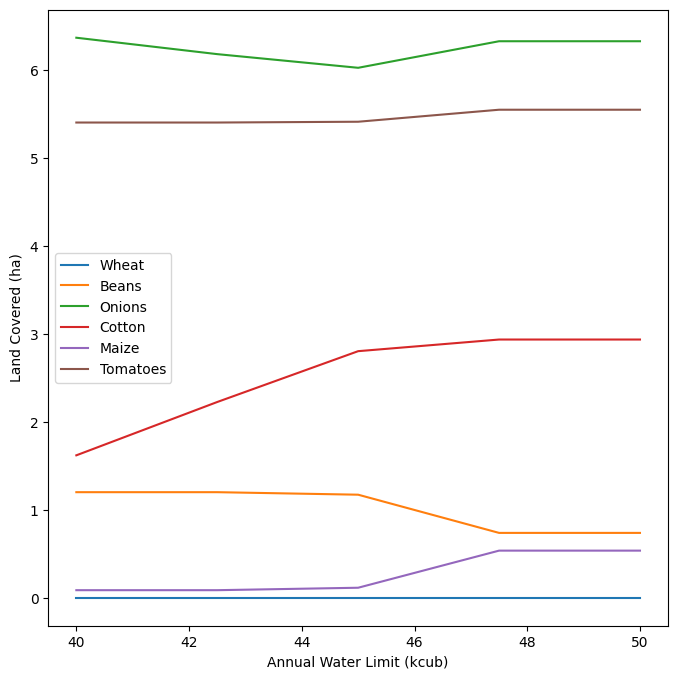

In [11]:
plt.figure(figsize=(8,8))
for i in range(len(Results)):
    plt.plot(W_range, Results.iloc[i,1:], label=Results.iloc[i,0])
plt.xlabel('Annual Water Limit (kcub)')
plt.ylabel('Land Covered (ha)')
plt.legend()